# Dynamic Time Warping Snap-To-Grid

This notebook demonstrates a snap-to-grid incorporating dynamic time warping (DTW). 

## A problem in snap-to-grid
Especially in downtown area where GNSS-based localization tend to be noisy, it is very effective to snap the estimated points to the ground truth positions. A simple snap-to-grid algorithm, however, does not consider time series information, which induces some problems such as:
- a point is snapped to different road, especially in crossroads
- a point is snapped to the left lane, in spite of the right lane rule in the US


## Dynamic Time Warping (DTW)
Dynamic time warping (DTW) is an algorithm for calculating the similarity between two time series data. Unlike other distance methods like Euclid, DTW is able to calculate the similarity of the shape of the data. The implementation can be simply done using dynamic programming.

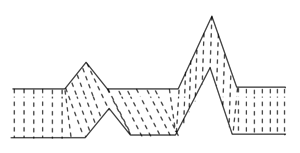

## DTW-based snap-to-grid
The algorithm is as follows: for every sub-trajectory query $(x_i)$ in the estimated data, 
1. find the closest sub-trajectory $(y_i)$ in ground truth data based on DTW
2. snap the query $(x_i)$ to the grid $(y_i)$

In our implementation, the length of $x_i$ is $60 [\rm{s}]$. Using this algorithm, you can avoid snapping a point to an opposite lane or to the different roads. 

In this competition, the method works pretty well on downtown area, where the multi-path errors are significant and plenty of ground truth data is available. For example on 2021-04-22-US-SJC-1, the score reduces from $18.4 [\rm{m}]$ to $11.7 [\rm{m}]$.

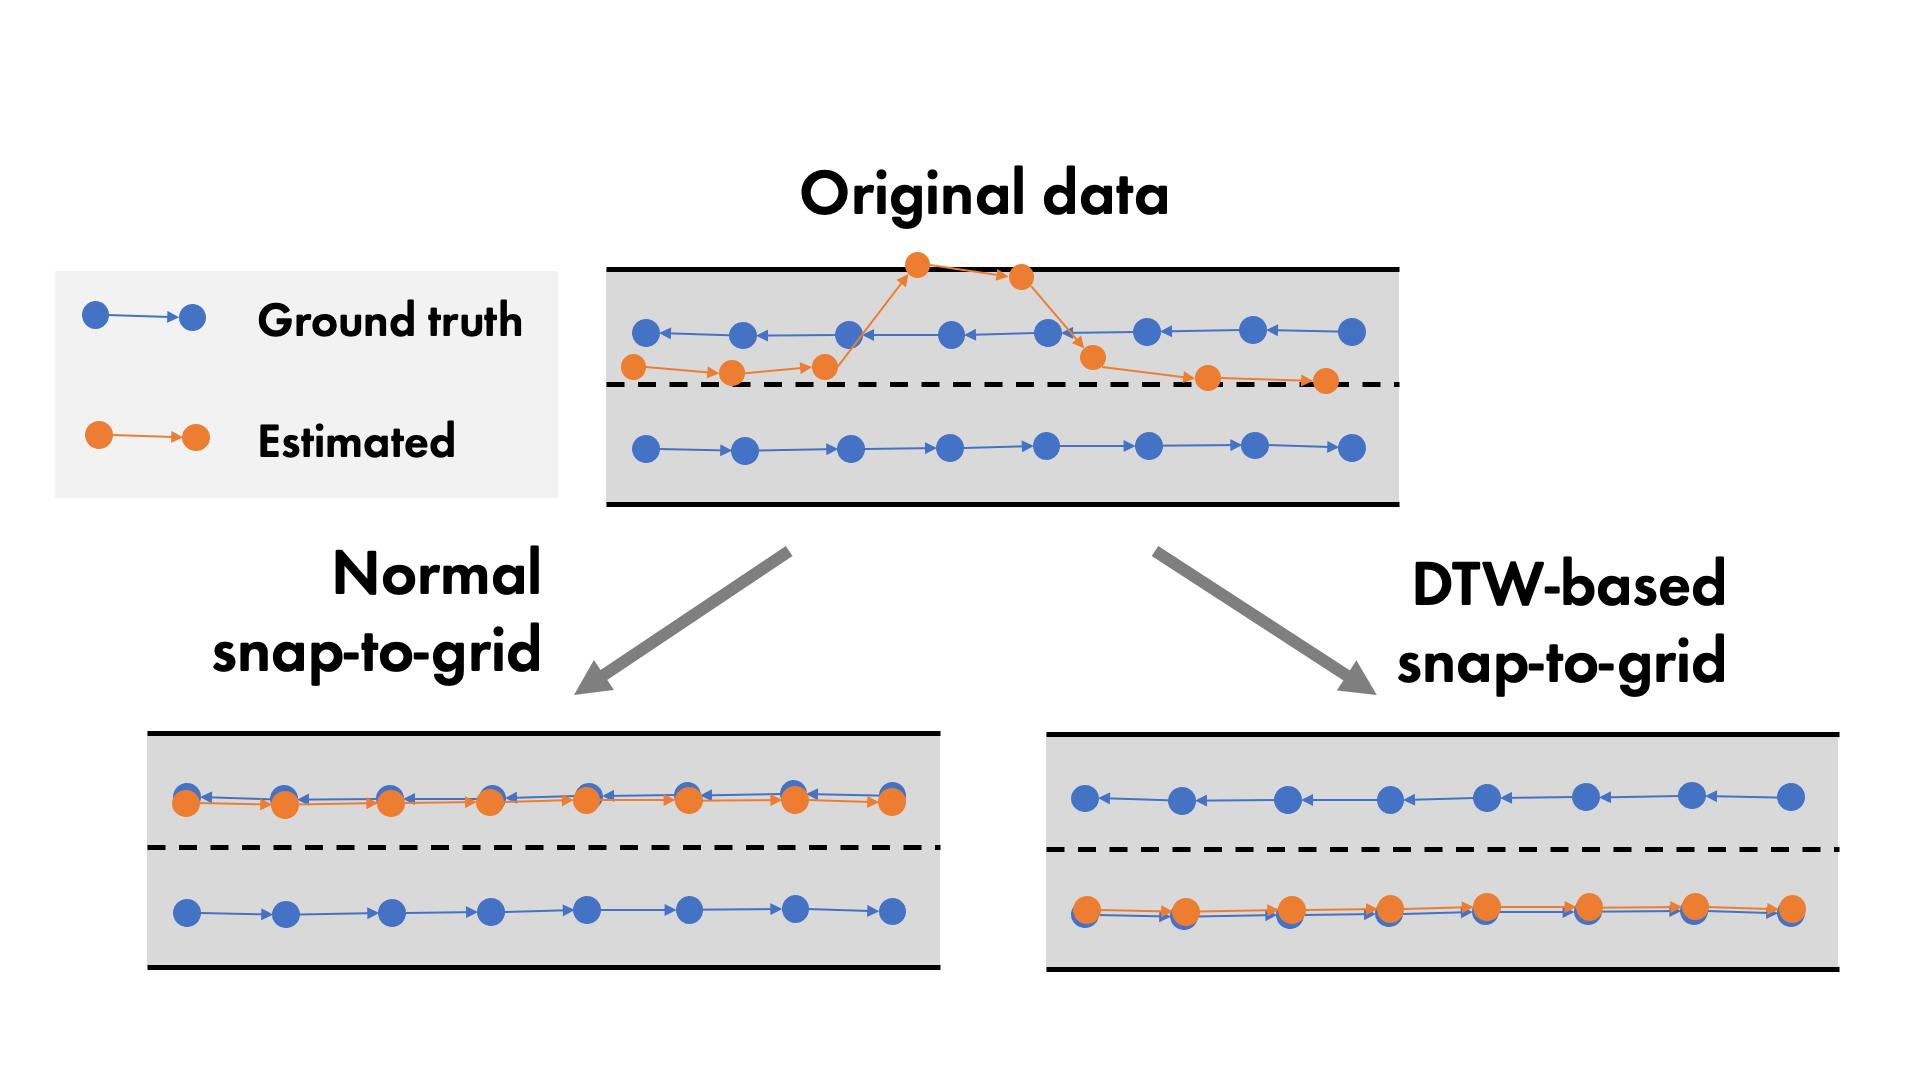

## Some tips
One of the drawbacks of DTW is the computational complexity. When calculating the distance between two time-series data whose length is $N$ and $M$ each, the complexity is $\mathcal{O}(MN)$. This is highly complex compared to other distance method such as Euclidean distance. Indeed, it took too much time to calculate between a query trajectory and all the possible sub-trajectory in ground truth data.

To overcome this issue, for each query trajectory $(x_i) = (x_0, x_1, \cdots, x_{n-1})$, we first pick up the points which is close enough to $x_0$ and $x_{n-1}$ each. Then, among the possible set of trajectory, we choose the trajectory with the closest DTW distance.

We also tried to apply this algorithm to highway and tree area, but did not work very well. 

In [ ]:
from pathlib import Path
import numpy as np
import pandas as pd
import copy
import plotly.express as px
import plotly.graph_objects as go
import pyproj
import json
import bisect
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from matplotlib.colors import ListedColormap, BoundaryNorm
import pickle
import random
from tqdm.notebook import tqdm

import warnings
warnings.simplefilter('ignore')
pd.set_option('display.max_rows',30)
pd.set_option('display.max_columns',None)

In [ ]:
def visualize_trafic(df, center={"lat":37.423576, "lon":-122.094132}, zoom=9):
    fig = px.scatter_mapbox(df,
                            
                            # Here, plotly gets, (x,y) coordinates
                            lat="latDeg",
                            lon="lngDeg",
                            
                            #Here, plotly detects color of series
                            color="phoneName",
                            labels="phoneName",
                            
                            zoom=zoom,
                            center=center,
                            height=300,
                            width=500)
    fig.update_layout(mapbox_style='stamen-terrain')
    fig.update_layout(margin={"r": 0, "t": 0, "l": 0, "b": 0})
    fig.update_layout(title_text="GPS trafic")
    fig.show()
    
def visualize_collection(df, collection, center={"lat":37.423576, "lon":-122.094132}, zoom=9):
    df_traj = df[df['collectionName'] == collection]
    visualize_trafic(df_traj, center, zoom)

In [ ]:
def calc_haversine(lat1, lon1, lat2, lon2):
    """Calculates the great circle distance between two points
    on the earth. Inputs are array-like and specified in decimal degrees.
    """
    RADIUS = 6_367_000
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat/2)**2 + \
        np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    dist = 2 * RADIUS * np.arcsin(a**0.5)
    return dist

In [ ]:
def percentile50(x):
    return np.percentile(x, 50)
def percentile95(x):
    return np.percentile(x, 95)

def get_train_score(df, gt):
    gt = gt.rename(columns={'latDeg':'latDeg_gt', 'lngDeg':'lngDeg_gt'})
    df = df.merge(gt, on=['collectionName', 'phoneName', 'millisSinceGpsEpoch'], how='inner')
    # calc_distance_error
    df['err'] = calc_haversine(df['latDeg_gt'], df['lngDeg_gt'], df['latDeg'], df['lngDeg'])
    # calc_evaluate_score
    df['phone'] = df['collectionName'] + '_' + df['phoneName']
    res = df.groupby('phone')['err'].agg([percentile50, percentile95])
    res['p50_p90_mean'] = (res['percentile50'] + res['percentile95']) / 2 
    score = res['p50_p90_mean'].mean()
    return score

In [ ]:
def eval_all(df_pred, df_gt):
    scores = []
    compared_cols = ["latDeg_truth","lngDeg_truth","latDeg_pred","lngDeg_pred"]
    collections = sorted(df_gt['collectionName'].unique())
    for collection in collections:
        df_pred_col = df_pred[df_pred['collectionName'] == collection]
        df_gt_col = df_gt[df_gt['collectionName'] == collection]
        
        score = get_train_score(df_pred_col, df_gt_col)
        
        df_merged = pd.merge_asof(df_gt_col.sort_values('millisSinceGpsEpoch'), df_pred_col.sort_values('millisSinceGpsEpoch'), 
                                  on="millisSinceGpsEpoch", by=["collectionName", "phoneName"], 
                                  direction='nearest',tolerance=100000, suffixes=('_truth', '_pred'))
        df_merged = df_merged.sort_values(by=["collectionName", "phoneName", "millisSinceGpsEpoch"], ignore_index=True)

        haversine = calc_haversine(*df_merged[compared_cols].to_numpy().transpose()).mean()
        scores.append([collection, haversine, score])
    
    score = get_train_score(df_pred, df_gt)
    df_merged = pd.merge_asof(df_gt.sort_values('millisSinceGpsEpoch'), df_pred.sort_values('millisSinceGpsEpoch'), 
                              on="millisSinceGpsEpoch", by=["collectionName", "phoneName"], 
                              direction='nearest',tolerance=100000, suffixes=('_truth', '_pred'))
    haversine = calc_haversine(*df_merged[compared_cols].to_numpy().transpose()).mean()
    scores.append(['all', haversine, score])
    
    df_scores = pd.DataFrame(scores, columns=['collection', 'haversine', 'score'])
    return df_scores

In [ ]:
def apply_dtw_snap_to_grid(df_input, df_gt, collections_to_snap = None, th_dtw=30.0 / 100_000, th_snap=10.0 / 100_000):
    df_snapped = df_input.copy()
    collections = df_snapped['collectionName'].unique()
    for collection in tqdm(collections, desc = 'Apply DTW snap-to-grid (for {} trajs)'.format("whole" if collections_to_snap is None else len(collections_to_snap))):
        if collections_to_snap is not None:
            if collection not in collections_to_snap:
                continue
        cond_col = df_snapped['collectionName'] == collection
        phones = df_snapped[cond_col]['phoneName'].unique()
        for phone in phones:
            cond_traj = cond_col & (df_snapped['phoneName'] == phone)
            time_traj = df_snapped[cond_traj]['millisSinceGpsEpoch'].values
            latlng_traj = df_snapped[cond_traj][['latDeg', 'lngDeg']].values

            segment_ids_list = get_segment_ids(latlng_traj, base_len=60, stride=30)
            
            snapped_count_list = np.zeros_like(time_traj)
            snapped_results_list = np.zeros((len(time_traj), 2))
            
            for ids in segment_ids_list:
                cond_seg = np.arange(0, latlng_traj.shape[0], 1)
                cond_seg = (cond_seg >= ids[0]) & (cond_seg < ids[1])
                latlng_seg = latlng_traj[cond_seg]
                snapped_count_list += cond_seg
                subtraj_opt, _ = search_closest_subtraj(latlng_seg, df_gt, threshold=th_dtw)
                if subtraj_opt is not None: # もし良い感じのが見つかったら、、、
                    grids = increase_points_array(subtraj_opt)
                    snapped_latlng = snap_to_grid_array(latlng_seg, grids, threshold=th_snap)
                    snapped_results_list[ids[0]:ids[1]] += snapped_latlng
                else:
                    snapped_results_list[ids[0]:ids[1]] += latlng_seg
            
            # Add original value if never counted.
            snapped_results_list[snapped_count_list == 0] += latlng_traj[snapped_count_list == 0]
            snapped_count_list[snapped_count_list == 0] += 1

            df_snapped.loc[cond_traj, ['latDeg', 'lngDeg']] = snapped_results_list / snapped_count_list.reshape(-1, 1)
    return df_snapped


def search_closest_subtraj(latlng, df_gt, threshold=30/100_000, expand_idx_len=10):
    
    dist_opt = 1e9
    subtraj_opt = None
    for collection, df_col in df_gt.groupby('collectionName'):
        # Phoneは1つだけ使えばOK
        phone_here = df_col['phoneName'].unique()[0]
        df_traj = df_col[df_col['phoneName'] == phone_here]
        latlng_traj = df_traj[['latDeg', 'lngDeg']].values
        
        dist_start = np.linalg.norm(latlng_traj - latlng[0, :], axis=1)
        dist_end = np.linalg.norm(latlng_traj - latlng[-1, :], axis=1)
        start_cand_idx = np.where(dist_start < threshold)[0]
        end_cand_idx = np.where(dist_end < threshold)[0]

        for start_idx in reduce_array(start_cand_idx):
            for end_idx in reduce_array(end_cand_idx):
                if start_idx >= end_idx:
                    continue
                dist = calc_dtw(latlng[::20], latlng_traj[start_idx: end_idx][::20])[-1][-1][0]
                # try:
                #     dist = calc_dtw(latlng[::20], latlng_traj[start_idx: end_idx][::20])[-1][-1][0]
                # except IndexError as e:
                #     print(start_idx, end_idx)
                if dist_opt > dist:
                    dist_opt = dist
                    subtraj_opt = latlng_traj[max(start_idx-expand_idx_len, 0): end_idx+expand_idx_len]

    return subtraj_opt, dist_opt


def increase_points_array(data, min_dist=0.2/100_000):
    data_increased = []
    for i, point in enumerate(data):
        if i == data.shape[0] - 1:
            continue
        data_increased.append(point)
        if np.array_equal(data[i, 1:], data[i + 1, 1:]):
            continue
        latDeg0 = data[i, 0]
        lngDeg0 = data[i, 1]
        latDeg1 = data[i+1, 0]
        lngDeg1 = data[i+1, 1]
        num_to_increase = np.ceil(np.linalg.norm([latDeg0 - latDeg1, lngDeg0 - lngDeg1]) / min_dist)
        for j in range(int(num_to_increase)):
            latDeg = ((num_to_increase-j) * latDeg0 + j * latDeg1) / num_to_increase
            lngDeg = ((num_to_increase-j) * lngDeg0 + j * lngDeg1) / num_to_increase
            data_increased.append([latDeg, lngDeg])
    data_increased = np.array(data_increased)
    return data_increased


def snap_to_grid_array(query, grids, threshold):
    snapped_query = copy.deepcopy(query)
    grids_sorted = np.array(sorted(grids, key=lambda x: x[0]))
    for i, point in enumerate(query):
        left_lat_idx = bisect.bisect_left(grids_sorted[:, 0], point[0] - threshold)
        right_lat_idx = bisect.bisect_left(grids_sorted[:, 0], point[0] + threshold)
        grids_of_interest = grids_sorted[left_lat_idx : right_lat_idx, :]
        if len(grids_of_interest) == 0:
            continue

        dist = np.linalg.norm(grids_of_interest - point, axis=1)        
        if np.min(dist) > threshold:
             continue
        idx_opt = np.argmin(dist)
        snapped_query[i] = grids_of_interest[idx_opt]
    return snapped_query


def reduce_array(array, length=50):
    reduced = []
    for idx in array:
        if len(reduced) == 0:
            reduced.append(idx)
        else:
            if reduced[-1] + length <= idx:
                reduced.append(idx)
    return reduced


def get_segment_ids(latlng, base_len=60, stride=30):
    segment_ids = []
    start = 0
    end = start + base_len
    while True:
        if np.linalg.norm(latlng[min(end, latlng.shape[0]-1), :] - latlng[start, :]) > 200/100_000: 
            segment_ids.append([start, end])
            start = end - stride
            end = start + base_len
        else:
            end += stride
        if end >= len(latlng):
            segment_ids.append([latlng.shape[0]-1 - 250, latlng.shape[0]-1])
            break
    return segment_ids


delta = lambda a, b: np.linalg.norm(a - b)
first = lambda x: x[0]
second = lambda x: x[1]

def minVal(v1, v2, v3):
    if first(v1) <= min(first(v2), first(v3)):
        return v1, 0
    elif first(v2) <= first(v3):
        return v2, 1
    else:
        return v3, 2 

def calc_dtw(A, B):
    S = len(A)
    T = len(B)

    m = [[0 for j in range(T)] for i in range(S)]
    m[0][0] = (delta(A[0],B[0]), (-1,-1))
    for i in range(1,S):
        m[i][0] = (m[i-1][0][0] + delta(A[i], B[0]), (i-1,0))
    for j in range(1,T):
        m[0][j] = (m[0][j-1][0] + delta(A[0], B[j]), (0,j-1))

    for i in range(1,S):
        for j in range(1,T):
            minimum, index = minVal(m[i-1][j], m[i][j-1], m[i-1][j-1])
            indexes = [(i-1,j), (i,j-1), (i-1,j-1)]
            m[i][j] = (first(minimum)+delta(A[i], B[j]), indexes[index])
    return m

# Train

In [ ]:
datapath = Path("../input/google-smartphone-decimeter-challenge/")
ground_truths = (datapath / "train").rglob("ground_truth.csv")
df_gt = pd.concat([pd.read_csv(filepath) for filepath in tqdm(ground_truths, total=73, desc="Reading ground truth data")], ignore_index=True)

df_pred_train = pd.read_csv('../input/k/minomonter/gnss-ensembled/train_submission_filtered.csv')
df_pred_train['collectionName'] = df_pred_train['phone'].apply(lambda x: x.split('_')[0])
df_pred_train['phoneName'] = df_pred_train['phone'].apply(lambda x: x.split('_')[1])

df_pred_test = pd.read_csv('../input/k/minomonter/gnss-ensembled/submission_filtered.csv')
df_pred_test['collectionName'] = df_pred_test['phone'].apply(lambda x: x.split('_')[0])
df_pred_test['phoneName'] = df_pred_test['phone'].apply(lambda x: x.split('_')[1])

In [ ]:
with open('../input/region-classification/region_type_train.json') as f:
    region_type_train = json.load(f)
with open('../input/region-classification/region_type_test.json') as f:
    region_type_test = json.load(f)

downtowns = [*[key for (key, val) in region_type_train.items() if 'downtown' in val], *[key for (key, val) in region_type_test.items() if 'downtown' in val]]
trees = [*[key for (key, val) in region_type_train.items() if 'tree' in val], *[key for (key, val) in region_type_test.items() if 'tree' in val]]
highways = [*[key for (key, val) in region_type_train.items() if 'tree' not in val and 'downtown' not in val],
          *[key for (key, val) in region_type_test.items() if 'tree' not in val and 'downtown' not in val]]

process_snap_to_grid_dtw_downtown_train = lambda df: apply_dtw_snap_to_grid(
    df,
    df_gt,
    collections_to_snap = downtowns,
    th_dtw=30.0 / 100_000,
    th_snap=50.0 / 100_000
)
process_snap_to_grid_dtw_downtown_test = lambda df: apply_dtw_snap_to_grid(
    df,
    df_gt,
    collections_to_snap = downtowns,
    th_dtw=30.0 / 100_000,
    th_snap=50.0 / 100_000
)

## Visualize baseline

In [ ]:
eval_all(df_gt, df_pred_train)

In [ ]:
visualize_collection(df_pred_train, '2021-04-29-US-SJC-2', center={"lat":37.333929, "lon":-121.888997}, zoom=14)

## Visualize DTW snap-to-grid results

In [ ]:
best_funcs = [
    process_snap_to_grid_dtw_downtown_train,
]

df_pred_train_processed = df_pred_train.copy()
for func in best_funcs:
    df_pred_train_processed = func(df_pred_train_processed)
    print(func.__name__, get_train_score(df_pred_train_processed, df_gt))

eval_all(df_pred_train_processed, df_gt)

In [ ]:
visualize_collection(df_pred_train_processed, '2021-04-29-US-SJC-2', center={"lat":37.333929, "lon":-121.888997}, zoom=14)

In [ ]:
df_pred_train_processed[['phone', 'millisSinceGpsEpoch', 'latDeg', 'lngDeg']].to_csv('train_submission.csv', index=False)

# Test

In [ ]:
visualize_trafic(df_pred_test)

In [ ]:
best_funcs = [
    process_snap_to_grid_dtw_downtown_test,
]

df_pred_test_processed = df_pred_test.copy()
for func in best_funcs:
    df_pred_test_processed = func(df_pred_test_processed)

# Visualize

In [ ]:
visualize_trafic(df_pred_test_processed)

# Submit

In [ ]:
sub = pd.read_csv('../input/google-smartphone-decimeter-challenge/sample_submission.csv')
sub = sub.assign(
    latDeg = df_pred_test_processed.latDeg,
    lngDeg = df_pred_test_processed.lngDeg
)
sub.to_csv('submission.csv', index=False)